# Data related tasks

This notebook is a toy example for loading the raw data, processing it to a dataset, saving it, and loading it again through the module.

In [1]:
import sys
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../src"))
# We change the working directory to the root of the project
# Run this only once
root_path = Path.cwd().parent
os.chdir(root_path)
sys.path.append(root_path / "src")


In [2]:
from echocem.data.data import CemDataset
from echocem.data.utils import get_raw_annotations_and_image

data_save_path = root_path / "data/processed/X_train/"
images_path = root_path / "data/raw/X_train/images/"

## How much data do we have?

And how is it organized?

In [19]:
filenames = os.listdir(images_path) # well_n_section_l_patch_m.npy
organized_content = {}
for filename in filenames:
    _, well, _, l, _, m = filename.split("_")
    m = m.split(".")[0]
    if well not in organized_content.keys():
        organized_content[well] = {}
    if l not in organized_content[well].keys():
        organized_content[well][l] = 0
    organized_content[well][l] += 1      


data = []
for puits, sections in sorted(organized_content.items(), key=lambda x: int(x[0])):
    for section in sorted(sections, key=lambda x: int(x)):
        data.append([puits, section, sections[section]])

df = pd.DataFrame(data, columns=["Puits", "Section", "Nombre de Patchs"])
print(f'Nombre de puits: {len(organized_content)}\n')
print(df.to_string(index=False))


Nombre de puits: 6

Puits Section  Nombre de Patchs
    1       0                37
    1       1                37
    1       2                37
    1       3                37
    1       4                37
    1       5                37
    1       6                37
    1       7                37
    1       8                37
    1       9                37
    1      10                37
    1      11                37
    1      12                37
    1      13                37
    1      14                37
    1      15                37
    1      16                37
    1      17                37
    2       0                32
    2       1                32
    2       2                32
    2       3                32
    2       4                32
    2       5                32
    2       6                32
    2       7                32
    2       8                32
    2       9                32
    2      10                32
    2      11       

Loading the annotations:

In [4]:
y_table = y = pd.read_csv(root_path / "data/raw/Y_train.csv", index_col=0)

An example of (annotation, data) pair:

In [37]:
filename = "well_1_section_2_patch_0.npy"
example_annotation, example_image = get_raw_annotations_and_image(y_table, images_path, filename=filename)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(example_annotation, cmap="gray")
plt.colorbar(ax[1].imshow(example_image, cmap="gray"), ax=ax[1])
ax[0].set_title("Annotation")
ax[1].set_title("Image")
plt.tight_layout()
fig.suptitle(f"Example of annotation and image for the file {filename}")
plt.tight_layout()
plt.show()

### Reprocessing the dataset

In [17]:
file_information = {
    'well': [],
    'section': [],
    'files': []
}

for file in filenames:
    _, well, _, l, _, m = file.split("_")
    m = m.split(".")[0]
    file_information['well'].append(well)
    file_information['section'].append(l)
    file_information['files'].append(file)

df = pd.DataFrame(file_information)

# group by well and section
df = df.groupby(['well', 'section']).agg({'files': list}).reset_index()

for index, row in df.iterrows():
    well = row['well']
    section = row['section']
    files = row['files']
    files = sorted(files, key=lambda x: int(x.split("_")[-1].split(".")[0]))
    print(f"Processing well {well} section {section}")
    # get the data and the image for each file
    y_and_x = [get_raw_annotations_and_image(y_table, images_path, filename=file) for file in files]
    # concatenate the data and the images
    ys = np.concatenate([y for y, _ in y_and_x], axis=0)
    xs = np.concatenate([x for _, x in y_and_x], axis=0)
    # save the data and the images
    os.makedirs(data_save_path / "annotations", exist_ok=True)
    os.makedirs(data_save_path / "images", exist_ok=True)
    np.save(data_save_path / f"annotations/{well}_{section}.npy", ys)
    np.save(data_save_path / f"images/{well}_{section}.npy", xs)

Processing well 1 section 0
Processing well 1 section 1
Processing well 1 section 10
Processing well 1 section 11
Processing well 1 section 12
Processing well 1 section 13
Processing well 1 section 14
Processing well 1 section 15
Processing well 1 section 16
Processing well 1 section 17
Processing well 1 section 2
Processing well 1 section 3
Processing well 1 section 4
Processing well 1 section 5
Processing well 1 section 6
Processing well 1 section 7
Processing well 1 section 8
Processing well 1 section 9
Processing well 2 section 0
Processing well 2 section 1
Processing well 2 section 10
Processing well 2 section 11
Processing well 2 section 12
Processing well 2 section 13
Processing well 2 section 14
Processing well 2 section 15
Processing well 2 section 16
Processing well 2 section 17
Processing well 2 section 18
Processing well 2 section 19
Processing well 2 section 2
Processing well 2 section 20
Processing well 2 section 21
Processing well 2 section 22
Processing well 2 section 2

### Loading the processed data

(1760, 160)


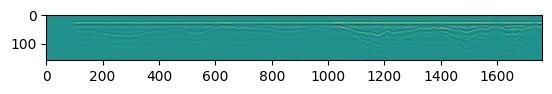

In [30]:
# try to load the data
data = np.load(data_save_path / "images/4_5.npy")
print(data.shape)
plt.imshow(data.T)
plt.show()

In [50]:
# Compute the mean and std of the training set
mean = 0
std = 0
n_files = 0
for file in (data_save_path / "images/").iterdir():
    if int(file.name.split('_')[0]) in [3, 4]:
        continue
    data = np.load(file)
    mean += np.mean(data)
    std += data.std() ** 2
    n_files += 1

mean /= n_files
std /= n_files
std = np.sqrt(std)
print(f"Mean: {mean}, std: {std}")

Mean: -0.2745382931759886, std: 28.799882604526953


In [51]:
dataset = CemDataset(images_path=data_save_path / "images/", annotations_path=data_save_path / "annotations/", excluded_wells=[2, 3, 4])
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
batch = next(iter(dataloader))

In [3]:
from hydra.utils import instantiate
from omegaconf import OmegaConf
# load the configuration file
cfg = OmegaConf.load("src/echocem/conf/data.yaml")
# instantiate the dataset
dataloader = instantiate(cfg.dataloader)

Preloading data into memory...


In [5]:
b1 = next(iter(dataloader))[0]
b1.std(), b1.mean()

(tensor(0.9751), tensor(6.6396e-05))